##### Setup

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display, HTML
import re
from datetime import datetime
import sys
from pathlib import Path



sys.path.insert(1, '/Users/nickkeesey/Desktop/learning-dynamics-behavior/src/utils')
import behavior_utils as bu
import array_utils as au
import load_utils as lu

In [2]:
# Load in preprocessed data
foraging_filepath = '/Users/nickkeesey/Desktop/learning-dynamics-behavior/data/foraging_trials_bonsai.csv'

foraging_df = pd.read_csv(foraging_filepath)

# Drop extraneous subject
foraging_df = foraging_df[foraging_df['subject_id'] != 111111]

foraging_df.sort_values(['subject_id', 'session_date', 'trial'], inplace=True)

/var/folders/mr/k7gx9xps333170k7zsggl4tw0000gn/T/ipykernel_5286/3084687691.py:4: DtypeWarning: Columns (31,38,40,42,52) have mixed types. Specify dtype option on import or set low_memory=False.
  foraging_df = pd.read_csv(foraging_filepath)


In [9]:
subject = 769887
date = '2024-11-04'
subject_df = foraging_df[foraging_df['subject_id'] == subject]
subject_df = subject_df[subject_df['session_date'] == date]

In [10]:
subject_df.columns.tolist()

['trial',
 'animal_response',
 'rewarded_historyL',
 'rewarded_historyR',
 'bait_left',
 'bait_right',
 'base_reward_probability_sum',
 'reward_probabilityL',
 'reward_probabilityR',
 'reward_random_number_left',
 'reward_random_number_right',
 'left_valve_open_time',
 'right_valve_open_time',
 'block_beta',
 'block_min',
 'block_max',
 'min_reward_each_block',
 'delay_beta',
 'delay_min',
 'delay_max',
 'delay_duration',
 'ITI_beta',
 'ITI_min',
 'ITI_max',
 'ITI_duration',
 'response_duration',
 'reward_consumption_duration',
 'auto_waterL',
 'auto_waterR',
 'laser_on_trial',
 'laser_wavelength',
 'laser_location',
 'laser_1_power',
 'laser_2_power',
 'laser_on_probability',
 'laser_duration',
 'laser_condition',
 'laser_condition_probability',
 'laser_start',
 'laser_start_offset',
 'laser_end',
 'laser_end_offset',
 'laser_protocol',
 'laser_frequency',
 'laser_rampingdown',
 'laser_pulse_duration',
 'session_wide_control',
 'fraction_of_session',
 'session_start_with',
 'session_a

In [15]:
testing_df = subject_df.loc[:, ['animal_response', 'rewarded_historyL', 'rewarded_historyR', 'reward_probabilityL', 'reward_probabilityR', 'auto_waterL', 'auto_waterR']]

print("\nDescriptive Statistics:")
print("-----------------------")
for col in testing_df.columns:
    print(f"\n{col}:")
    print("Data type:", testing_df[col].dtype)
    print("Number of unique values:", testing_df[col].nunique())
    print("Missing values:", testing_df[col].isnull().sum())
    if testing_df[col].dtype in ['int64', 'float64']:
        if col in ['auto_waterL', 'auto_waterR']:
            print("Value counts:")
            print("1:", (testing_df[col] == 1).sum())
            print("0:", (testing_df[col] == 0).sum())
        else:
            print("Mean:", testing_df[col].mean())
            print("Std:", testing_df[col].std())
            print("Min:", testing_df[col].min())
            print("Max:", testing_df[col].max())
    if testing_df[col].dtype == 'bool':
        print("Value counts:")
        print("1 (True):", (testing_df[col] == 1).sum())
        print("0 (False):", (testing_df[col] == 0).sum())
    print("-----------------------")

print("\nFirst few rows of the dataframe:")
print("\nShape of dataframe:", testing_df.shape)
print("\nLength of each column:")
for col in testing_df.columns:
    print(f"{col}: {len(testing_df[col])}")


Descriptive Statistics:
-----------------------

animal_response:
Data type: float64
Number of unique values: 3
Missing values: 0
Mean: 1.0875420875420876
Std: 0.8686480467287573
Min: 0.0
Max: 2.0
-----------------------

rewarded_historyL:
Data type: bool
Number of unique values: 2
Missing values: 0
Value counts:
1 (True): 30
0 (False): 564
-----------------------

rewarded_historyR:
Data type: bool
Number of unique values: 2
Missing values: 0
Value counts:
1 (True): 29
0 (False): 565
-----------------------

reward_probabilityL:
Data type: float64
Number of unique values: 3
Missing values: 0
Mean: 0.2956228956228957
Std: 0.3976503916051249
Min: 0.0
Max: 1.0
-----------------------

reward_probabilityR:
Data type: float64
Number of unique values: 3
Missing values: 0
Mean: 0.5215488215488214
Std: 0.39230407529669264
Min: 0.0
Max: 1.0
-----------------------

auto_waterL:
Data type: int64
Number of unique values: 2
Missing values: 0
Value counts:
1: 72
0: 522
-----------------------

a

In [18]:
def add_block_transitions_and_stats_filt(df):
    """
    Identifies block transitions and calculates block statistics for a foraging dataframe.
    """
    # Identify block transitions based on probability changes
    block_transitions = ((df['reward_probabilityL'].shift() != df['reward_probabilityL']) | 
                        (df['reward_probabilityR'].shift() != df['reward_probabilityR'])).astype(int)
    
    # First trial is always a block transition (matching numpy version)
    block_transitions.iloc[0] = 1
    
    # Create unique block numbers within each session
    df['block'] = block_transitions.groupby([df['subject_id'], 
                                           df['session_date']]).cumsum() - 1  # Subtract 1 to start at 0
    
    # Calculate block statistics
    block_lengths = df.groupby(['subject_id', 'session_date', 'block']).size()
    block_stats = block_lengths.groupby(['subject_id', 'session_date']).agg(['max', 'median'])
    
    # Add block statistics back to original dataframe
    df['max_block_length'] = df.set_index(['subject_id', 'session_date']).index.map(block_stats['max'])
    df['median_block_length'] = df.set_index(['subject_id', 'session_date']).index.map(block_stats['median'])
    
    return df

In [19]:
subject_df_filt = add_block_transitions_and_stats_filt(subject_df)
subject_df_filt.head()

,trial,animal_response,rewarded_historyL,rewarded_historyR,bait_left,bait_right,base_reward_probability_sum,reward_probabilityL,reward_probabilityR,reward_random_number_left,...,choice_time_in_trial,earned_reward,extra_reward,subject_id,session_date,reward_delay,minimum_opto_interval,block,max_block_length,median_block_length
1128082,0,2.0,False,False,True,False,1.0,1.0,0.0,0.391593,...,NaN,False,True,769887,2024-11-04,0.0,0.0,0,175,1.0
1128083,1,2.0,False,False,True,False,1.0,1.0,0.0,0.496597,...,NaN,False,True,769887,2024-11-04,0.0,0.0,0,175,1.0
1128084,2,2.0,False,False,True,False,1.0,1.0,0.0,0.447407,...,NaN,False,True,769887,2024-11-04,0.0,0.0,0,175,1.0
1128085,3,2.0,False,False,True,False,1.0,1.0,0.0,0.711119,...,NaN,False,True,769887,2024-11-04,0.0,0.0,0,175,1.0
1128086,4,2.0,False,False,True,False,1.0,1.0,0.0,0.069131,...,NaN,False,True,769887,2024-11-04,0.0,0.0,0,175,1.0


In [20]:
# Define chosen metric difference function

def chosen_metric_difference(df, global_calc=True):
    """
    Current difference calculation method
    """
    grouped = df.groupby(['subject_id', 'session_date'])
    results = []
    
    for (subject, date), session_df in grouped:
        session_df['probability_chosen'] = np.where(
            session_df['animal_response'] == 0,
            session_df['reward_probabilityL'],
            session_df['reward_probabilityR']
        )
        session_df['probability_not_chosen'] = np.where(
            session_df['animal_response'] == 0,
            session_df['reward_probabilityR'],
            session_df['reward_probabilityL']
        )
        
        if global_calc:
            difference = session_df['probability_chosen'] - session_df['probability_not_chosen']
            
            p_larger_global = max(session_df['probability_chosen'].max(), 
                                session_df['probability_not_chosen'].max())
            p_smaller_global = min(session_df['probability_chosen'].min(), 
                                 session_df['probability_not_chosen'].min())
            
            if p_larger_global == p_smaller_global:
                continue
                
            final_metric = difference.mean() / (p_larger_global - p_smaller_global)
            
            results.append({
                'subject_id': subject,
                'session_date': date,
                'chosen_metric': final_metric,
            })
            
        else:
            block_metrics = []
            
            for block_num, block_df in session_df.groupby('block'):
                difference = block_df['probability_chosen'] - block_df['probability_not_chosen']
                
                p_larger_block = max(block_df['probability_chosen'].max(),
                                   block_df['probability_not_chosen'].max())
                p_smaller_block = min(block_df['probability_chosen'].min(),
                                    block_df['probability_not_chosen'].min())
                
                if p_larger_block == p_smaller_block:
                    continue
                    
                block_metric = difference.mean() / (p_larger_block - p_smaller_block)
                block_metrics.append(block_metric)
            
            if block_metrics:
                results.append({
                    'subject_id': subject,
                    'session_date': date,
                    'chosen_metric': np.mean(block_metrics),
                })
    
    return pd.DataFrame(results)

In [23]:
diff_local_filt = chosen_metric_difference(subject_df_filt, global_calc=False)
diff_global_filt = chosen_metric_difference(subject_df_filt, global_calc=True)

print(f'local_metric: {diff_local_filt["chosen_metric"]}')
print(f'global_metric: {diff_global_filt["chosen_metric"]}')

local_metric: 0    0.722261
Name: chosen_metric, dtype: float64
global_metric: 0    0.065657
Name: chosen_metric, dtype: float64


In [67]:
# Create chosen metric DataFrames

diff_global = chosen_metric_difference(foraging_df, global_calc=True)
diff_local = chosen_metric_difference(foraging_df, global_calc=False)

# Compare results
diff_all = pd.concat([
    diff_global.assign(method='diff_global'),
    diff_local.assign(method='diff_local'),
])

In [107]:
diff_local_filt

,subject_id,session_date,chosen_metric
0,567890,2024-11-01,1.000000
1,641733,2024-01-24,-1.000000
2,684039,2023-10-25,0.326422
3,684039,2023-10-26,0.352656
4,684039,2023-10-27,0.219818
...,...,...,...
5258,769887,2024-11-06,-0.020706
5259,769888,2024-11-04,0.755944
5260,769888,2024-11-07,0.205583
5261,769888,2024-11-08,0.258780


In [108]:
subject = 769887
date = '2024-12-09'

diff_local_filt['session_date'] = diff_local_filt['session_date'].astype('datetime64[ns]')
diff_local_filt['subject_id'] = diff_local_filt['subject_id'].astype('int64')

individual_local = diff_local_filt[diff_local_filt['subject_id'] == subject]

individual_local

,subject_id,session_date,chosen_metric
5257,769887,2024-11-04,0.722261
5258,769887,2024-11-06,-0.020706


In [69]:
# Load in session level metrics 

session_metrics = pd.read_csv('/Users/nickkeesey/Desktop/learning-dynamics-behavior/data/filtered_data_20241107.csv')
session_metrics['session_date'] = session_metrics['session_date'].astype('datetime64[ns]')

/var/folders/mr/k7gx9xps333170k7zsggl4tw0000gn/T/ipykernel_82248/1577903200.py:3: DtypeWarning: Columns (6,7,8,11,26,27,28,29,30,133,134,149,150,151,152,153,154,155,156,157,158,159,160,161) have mixed types. Specify dtype option on import or set low_memory=False.
  session_metrics = pd.read_csv('/Users/nickkeesey/Desktop/learning-dynamics-behavior/data/filtered_data_20241107.csv')


In [70]:
session_metrics.sort_values(['subject_id', 'session_date'], inplace=True)
session_metrics.head()

,subject_id,session_date,nwb_suffix,session,rig,user_name,curriculum_name,curriculum_version,current_stage_actual,task,...,subject_genotype,fiber_probes,injections,task_type,virus,NM_recorded,results,results_location,session_time,docDB_status
8915,447921,2019-09-11,135646,1.0,Training-Tower-3_bpod,Nai-Wen Tien,NaN,NaN,NaN,Coupled Baiting,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0_not uploaded
8906,447921,2019-09-12,212547,2.0,Training-Tower-3_bpod,Nai-Wen Tien,NaN,NaN,NaN,Coupled Baiting,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0_not uploaded
8905,447921,2019-09-13,155249,3.0,Training-Tower-3_bpod,Nai-Wen Tien,NaN,NaN,NaN,Coupled Baiting,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0_not uploaded
8898,447921,2019-09-14,153203,4.0,Training-Tower-3_bpod,Nai-Wen Tien,NaN,NaN,NaN,Coupled Baiting,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0_not uploaded
8897,447921,2019-09-15,122712,5.0,Training-Tower-3_bpod,Nai-Wen Tien,NaN,NaN,NaN,Coupled Baiting,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0_not uploaded


##### preprocessing

In [109]:
# Merge calculated metrics with session metrics 

diff_all['session_date'] = diff_all['session_date'].astype('datetime64[ns]')
diff_global['session_date'] = diff_global['session_date'].astype('datetime64[ns]')
diff_local['session_date'] = diff_local['session_date'].astype('datetime64[ns]')

diff_all_merged = bu.merge_dataframes_subject_id(diff_all, session_metrics)
diff_global_merged = bu.merge_dataframes_subject_id(diff_global, session_metrics)
diff_local_merged = bu.merge_dataframes_subject_id(diff_local, session_metrics)

diff_local_filt_merged = bu.merge_dataframes_subject_id(diff_local_filt, session_metrics)

pd.set_option('future.no_silent_downcasting', True)

# Remove extraneous columns

extraneous_columns = [ 'nwb_suffix',
 'rig',
 'user_name',
 'notes',
 'experiment_description',
 'session_start_time',
 'session_end_time',
 'session_run_time_in_min',
 'base_weight',
 'target_weight',
 'target_weight_ratio',
 'weight_after',
 'laser_1_calibration_power',
 'laser_2_calibration_power',
 'laser_1_target_areas',
 'laser_2_target_areas',
 'commit_ID',
 'repo_url',
 'current_branch',
 'lickspout_movement_range_x',
 'lickspout_movement_range_y',
 'lickspout_movement_range_z',
 'lickspout_initial_pos_x',
 'lickspout_initial_pos_y',
 'lickspout_initial_pos_z',
 'lickspout_median_pos_x',
 'lickspout_median_pos_y',
 'lickspout_median_pos_z',
 'has_video',
 'has_ephys',
 'old_bpod_session',
 'h2o',
 'institute',
 'rig_type',
 'room',
 'hardware',
 'data_source',
'location',
 'session_name',
 'creation_time',
 'co_data_asset_ID',
 'subject_genotype',
 'fiber_probes',
 'injections',
 'task_type',
 'virus',
 'NM_recorded',
 'results',
 'results_location',
 'session_time',
 'docDB_status'
 ]

diff_all_merged = bu.remove_columns(diff_all_merged, extraneous_columns)
diff_global_merged = bu.remove_columns(diff_global_merged, extraneous_columns)
diff_local_merged = bu.remove_columns(diff_local_merged, extraneous_columns)
diff_local_filt_merged = bu.remove_columns(diff_local_filt_merged, extraneous_columns)
# Clean DataFrames

diff_all_merged = bu.clean_dataframe(diff_all_merged, threshold=0.1)
diff_global_merged = bu.clean_dataframe(diff_global_merged, threshold=0.1)
diff_local_merged = bu.clean_dataframe(diff_local_merged, threshold=0.1)
diff_local_filt_merged = bu.clean_dataframe(diff_local_filt_merged, threshold=0.1)
# Add session column 'new_sesssion

diff_all_comp= bu.add_session_column(diff_all_merged)
diff_global_comp = bu.add_session_column(diff_global_merged)
diff_local_comp = bu.add_session_column(diff_local_merged)
diff_local_filt_comp = bu.add_session_column(diff_local_filt_merged)


Original DataFrame shape: (8996, 114)
Cleaned DataFrame shape: (8838, 114)

Original DataFrame shape: (4498, 113)
Cleaned DataFrame shape: (4419, 113)

Original DataFrame shape: (4498, 113)
Cleaned DataFrame shape: (4419, 113)

Original DataFrame shape: (4498, 113)
Cleaned DataFrame shape: (4419, 113)


In [72]:
# Not working

def normalize_by_block_length(df, median=False, max=False):
    """
    Normalize metrics by block length by dividing chosen_metric by either the median or max block length.
    
    Parameters:
        df (pd.DataFrame): DataFrame containing metrics to normalize
        median (bool): If True, normalize by effective_block_length_median
        max (bool): If True, normalize by effective_block_length_max
        
    Returns:
        pd.DataFrame: DataFrame with normalized chosen_metric and first 5 sessions removed
    """
    # Remove first 5 sessions
    df = df[df['new_session'] > 5].copy()
    
    if median:
        df['chosen_metric'] = (df['chosen_metric'] / df['effective_block_length_median']) * 1000
    elif max:
        df['chosen_metric'] = (df['chosen_metric'] / df['effective_block_length_max']) * 1000
    return df

In [73]:
norm_local_median = normalize_by_block_length(diff_local_comp, median=True)
norm_local_max = normalize_by_block_length(diff_local_comp, max=True)

norm_global_median = normalize_by_block_length(diff_global_comp, median=True)
norm_global_max = normalize_by_block_length(diff_global_comp, max=True)

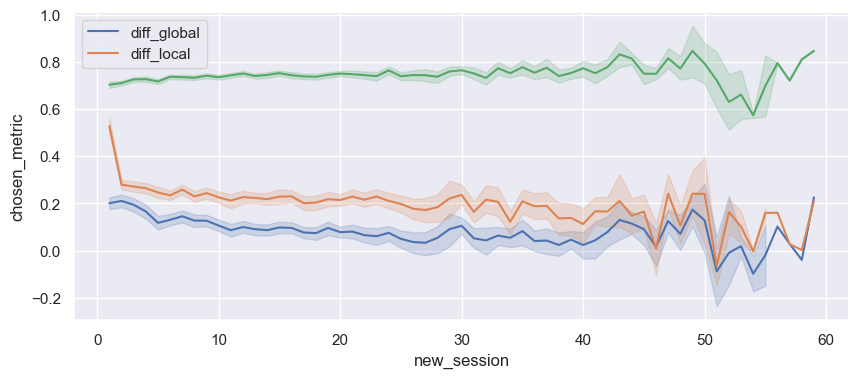

In [74]:
plt.figure(figsize=(10, 4))
sns.lineplot(diff_all_comp, x='new_session', y='chosen_metric', hue='method')
sns.lineplot(diff_all_comp, x='new_session', y='foraging_eff_random_seed')
plt.legend()

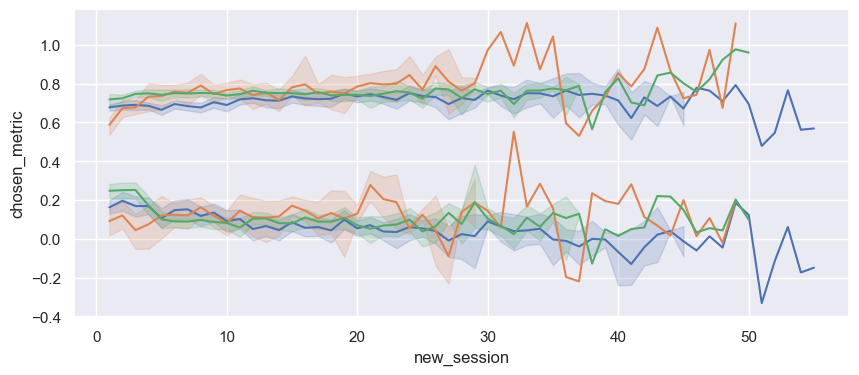

In [75]:
plt.figure(figsize=(10, 4))
sns.lineplot(diff_global_comp, x='new_session', y='chosen_metric', hue='curriculum_name')
sns.lineplot(diff_global_comp, x='new_session', y='foraging_eff_random_seed', hue='curriculum_name')
plt.legend().remove()

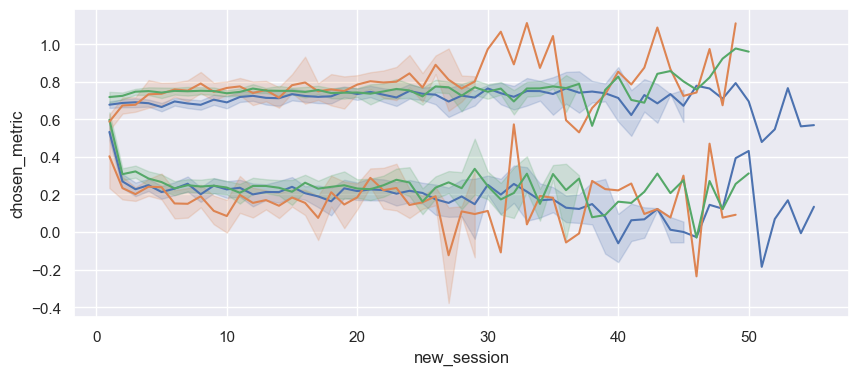

In [76]:
plt.figure(figsize=(10, 4))
sns.lineplot(diff_local_comp, x='new_session', y='chosen_metric', hue='curriculum_name')
sns.lineplot(diff_local_comp, x='new_session', y='foraging_eff_random_seed', hue='curriculum_name')
plt.legend().remove()

##### filtering

In [77]:
# Explore version

version_dict = bu.analyze_column_distribution(diff_all_comp, 'curriculum_version')
version_dict


{'value_counts': curriculum_version
 2.3                 2074
 2.2                  790
 1.0                  742
 2.3.1rwdDelay159     712
 2.2.1rwdDelay159     634
 2.0                  306
 2.1rwdDelay159       266
 2.2rwdDelay159       170
 2.1                  146
 2.3rwdDelay159       104
 0.1                   56
 0.1                    2
 Name: count, dtype: int64,
 'percentages': curriculum_version
 2.3                 34.555148
 2.2                 13.162279
 1.0                 12.362546
 2.3.1rwdDelay159    11.862712
 2.2.1rwdDelay159    10.563146
 2.0                  5.098301
 2.1rwdDelay159       4.431856
 2.2rwdDelay159       2.832389
 2.1                  2.432522
 2.3rwdDelay159       1.732756
 0.1                  0.933022
 0.1                  0.033322
 Name: proportion, dtype: float64,
 'total_count': 8838,
 'unique_values': 12,
 'most_common': ('2.3', 2074),
 'least_common': ('0.1', 2)}

In [113]:
# Filter by curriculum version
filtered_local = bu.filter_by_column(diff_local_comp, 'curriculum_version', '2.3')
filtered_global = bu.filter_by_column(diff_global_comp, 'curriculum_version', '2.3')
filtered_all = bu.filter_by_column(diff_all_comp, 'curriculum_version', '2.3')

filtered_local_filt = bu.filter_by_column(diff_local_filt_comp, 'curriculum_version', '2.3')
# Filter by stage
filtered_local = bu.filter_by_column(filtered_local, 'current_stage_actual', 'STAGE_FINAL')
filtered_global = bu.filter_by_column(filtered_global, 'current_stage_actual', 'STAGE_FINAL')
filtered_all = bu.filter_by_column(filtered_all, 'current_stage_actual', 'STAGE_FINAL')

filtered_local_filt = bu.filter_by_column(filtered_local_filt, 'current_stage_actual', 'STAGE_FINAL')

# Filter by task
filtered_local = bu.filter_by_column(filtered_local, 'task', 'Uncoupled Baiting', reset_sessions=True)
filtered_global = bu.filter_by_column(filtered_global, 'task', 'Uncoupled Baiting', reset_sessions=True)
filtered_all = bu.filter_by_column(filtered_all, 'task', 'Uncoupled Baiting', reset_sessions=True)

filtered_local_filt = bu.filter_by_column(filtered_local_filt, 'task', 'Uncoupled Baiting', reset_sessions=True)

In [79]:
filtered_all['task'].unique()

array(['Uncoupled Baiting'], dtype=object)

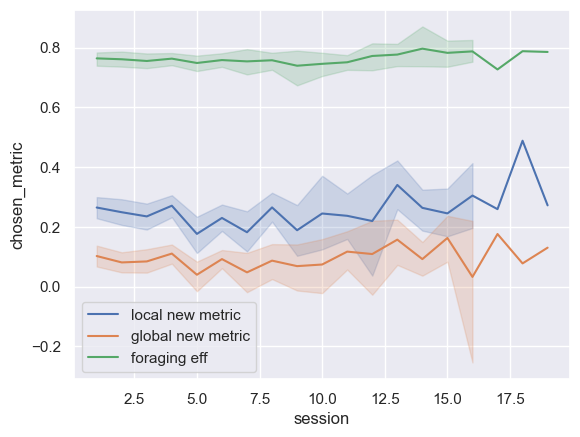

In [80]:
sns.lineplot(filtered_local, x='session', y='chosen_metric', label='local new metric')
sns.lineplot(filtered_global, x='session', y='chosen_metric', label='global new metric')
sns.lineplot(filtered_local, x='session', y='foraging_eff_random_seed', label='foraging eff')

plt.legend()

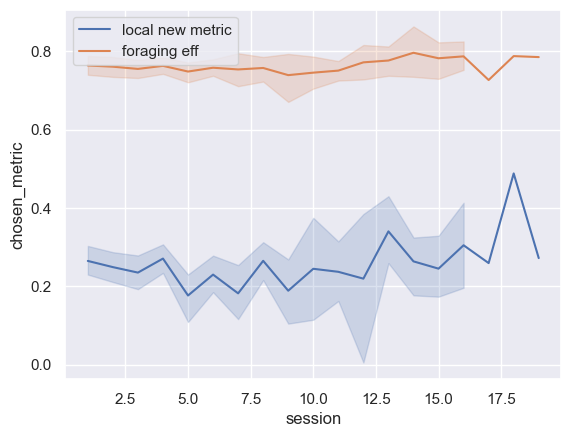

In [114]:
sns.lineplot(filtered_local_filt, x='session', y='chosen_metric', label='local new metric')
sns.lineplot(filtered_local_filt, x='session', y='foraging_eff_random_seed', label='foraging eff')

plt.legend()